# Detecção de Embarcações em Ambientes Marinhos Usando Deep Learning Aplicado à Bioacústica

## Importando todas as Libs que serão necessárias 

In [75]:
# import necessary libraries
import os
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import librosa
import random

## Definindo Constantes e funções auxiliares

In [76]:
# === CONFIGURAÇÕES ===
INPUT_SHAPE = (513, 27, 1)
PATH_BARCO = '../pxx_barcos'
PATH_NORMAL = '../pxxs_normais'
SEED = 42

In [77]:
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [78]:
def augment_noise(data, std=0.01, copies=3, seed=42):
    """
    Realiza data augmentation adicionando ruído gaussiano às matrizes de entrada.

    Esta função recebe uma lista de matrizes (por exemplo, espectrogramas ou Mel Spectrograms)
    e retorna uma lista aumentada, onde para cada matriz original são geradas
    'copies' versões com ruído gaussiano adicionado. Útil para aumentar
    a variabilidade do dataset e ajudar na generalização do modelo.

    Parâmetros
    ----------
    data : list or array-like
        Lista de matrizes de entrada a serem aumentadas (shape ex: [N, 128, 27]).

    std : float, opcional (default=0.01)
        Desvio padrão do ruído gaussiano a ser adicionado.

    copies : int, opcional (default=3)
        Número de cópias aumentadas a serem geradas para cada matriz original.

    seed : int, opcional (default=42)
        Semente para o gerador de números aleatórios, garantindo reprodutibilidade.

    Retorno
    -------
    augmented : list
        Lista contendo todas as cópias aumentadas com ruído.

    Exemplo
    -------
    >>> augmented_data = augment_noise(mel_spectrograms, std=0.02, copies=5)
    >>> print(len(augmented_data))  # Deve ser igual a len(mel_spectrograms) * 5
    """
    augmented = []
    rng = np.random.default_rng(seed)
    for sample in data:
        for _ in range(copies):
            noisy = sample + rng.normal(0, std, sample.shape)
            augmented.append(noisy)
    return augmented


In [79]:
def carregar_mel_h5(path, label, sr=8000, n_fft=1024, n_mels=128):
    """
    Carrega matrizes Pxx de arquivos .h5 e converte para Mel Spectrograms prontos para CNN.

    Esta função percorre todos os arquivos .h5 em um diretório fornecido, extrai a matriz 'pxx' de cada arquivo,
    projeta a matriz de densidade espectral para a escala Mel utilizando um banco de filtros Mel,
    converte para escala dB e redimensiona para shape fixo. Ideal para pipelines de Deep Learning
    com entradas espectrais.

    Parâmetros
    ----------
    path : str
        Caminho para a pasta onde estão os arquivos .h5 com a matriz 'pxx' salva.

    label : int
        Rótulo (classe) a ser atribuído para todas as matrizes carregadas deste diretório (ex: 0=normal, 1=barco).

    sr : int, opcional (default=8000)
        Taxa de amostragem em Hz utilizada para construir o banco de filtros Mel.

    n_fft : int, opcional (default=1024)
        Tamanho da janela FFT utilizada na geração das matrizes Pxx.

    n_mels : int, opcional (default=128)
        Número de bandas Mel para a projeção.

    Retorno
    -------
    data : list of np.ndarray
        Lista de Mel Spectrograms convertidos, já redimensionados e prontos para uso em CNN
        (shape de cada item: [128, 27, 1]).

    labels : list of int
        Lista de rótulos, um para cada matriz carregada.

    Exemplo
    -------
    >>> X, y = carregar_mel_h5('./pxx_barcos', label=1)
    >>> print(X[0].shape)  # (128, 27, 1)
    >>> print(y[:5])       # [1, 1, 1, 1, 1]
    """
    data = []
    labels = []
    mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)

    for file in os.listdir(path):
        if file.endswith(".h5"):
            file_path = os.path.join(path, file)
            with h5py.File(file_path, 'r') as h5_file:
                pxx = np.array(h5_file['pxx'])

                if pxx.shape[0] != mel_basis.shape[1]:
                    continue  # pula arquivos incompatíveis

                mel_pxx = np.dot(mel_basis, pxx)
                mel_db = librosa.power_to_db(mel_pxx, ref=np.max)

                # Redimensiona para CNN
                mel_db = np.resize(mel_db, (128, 27))
                data.append(mel_db[..., np.newaxis])  # shape (128, 27, 1)
                labels.append(label)

    return data, labels


## Carregando os dados 

In [80]:
# Carregamento
dados_barcos, rotulos_barcos = carregar_mel_h5(PATH_BARCO, label=1)
dados_normais, rotulos_normais = carregar_mel_h5(PATH_NORMAL, label=0)


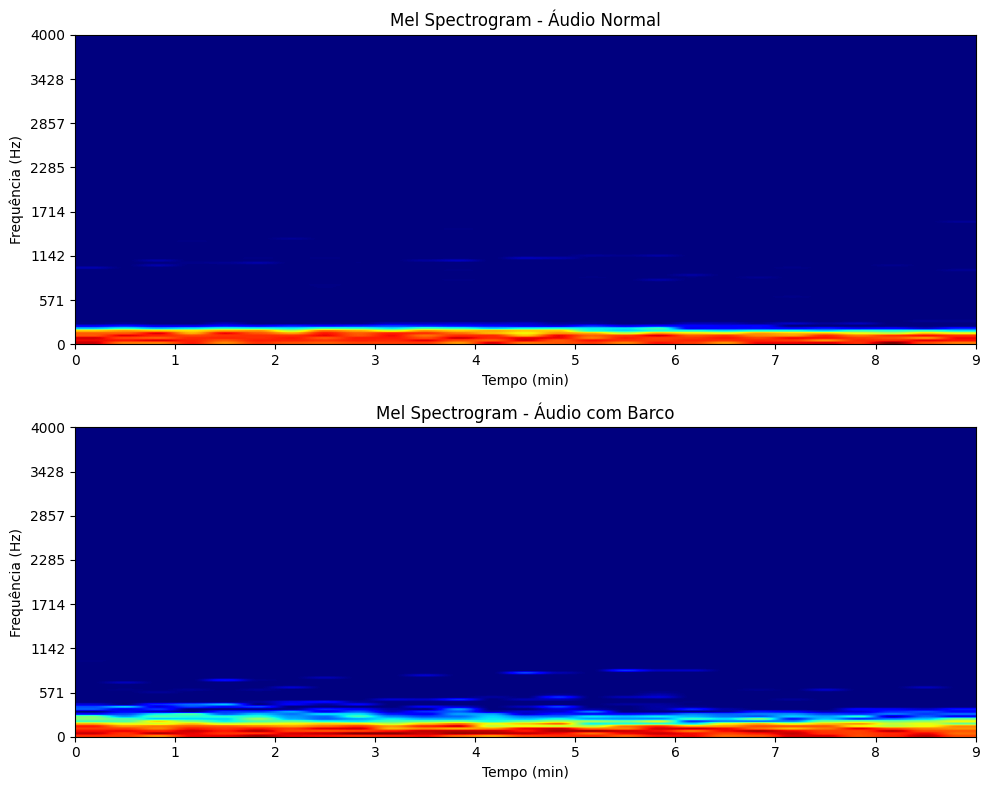

In [81]:
# Pegue uma amostra de cada classe
mel_normal = dados_normais[0]  # shape (128, 27, 1)
mel_barco = dados_barcos[0]    # shape (128, 27, 1)

# Remover o eixo extra se necessário
if mel_normal.ndim == 3:
    mel_normal = mel_normal.squeeze()
if mel_barco.ndim == 3:
    mel_barco = mel_barco.squeeze()

plt.figure(figsize=(10, 8))

# Frequências Mel para os labels do eixo y
mel_f = librosa.mel_frequencies(n_mels=128, fmin=0, fmax=8000//2)
extent = [0, 9, mel_f[0], mel_f[-1]]

# Plot Mel Normal
plt.subplot(2, 1, 1)
plt.imshow(mel_normal, aspect='auto', origin='lower', cmap='jet', extent=extent)
plt.title("Mel Spectrogram - Áudio Normal")
plt.ylabel("Frequência (Hz)")
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.linspace(mel_f[0], mel_f[-1], 8).astype(int))
plt.xlabel("Tempo (min)")

# Plot Mel Barco
plt.subplot(2, 1, 2)
plt.imshow(mel_barco, aspect='auto', origin='lower', cmap='jet', extent=extent)
plt.title("Mel Spectrogram - Áudio com Barco")
plt.ylabel("Frequência (Hz)")
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.linspace(mel_f[0], mel_f[-1], 8).astype(int))
plt.xlabel("Tempo (min)")

plt.tight_layout()
plt.show()


### Aumentando os dados com ruido Gaussiano

In [82]:
# Aumenta classe barco
dados_barcos_aug = augment_noise(dados_barcos, std=0.01, copies=3)
rotulos_barcos_aug = [1] * len(dados_barcos_aug)

# Junta tudo
X = np.array(dados_normais + dados_barcos + dados_barcos_aug)
y = np.array(rotulos_normais + rotulos_barcos + rotulos_barcos_aug)

### Dividindo dados em Treino e Teste

In [83]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Aplicando Peso por Classe

In [84]:
# Pesos de classe
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))


### Explicação de Data Augmentation (noise) + compute_class_weight
O uso **simultâneo de Data Augmentation (noise) e de `compute_class_weight`** não é redundante. Eles atuam em **frentes diferentes** e **se complementam** para melhorar a robustez do modelo, especialmente em datasets desbalanceados e pequenos. Veja a explicação detalhada:

---

#### **1. Augmentation com Noise**

```python
dados_barcos_aug = augment_noise(dados_barcos, std=0.01, copies=3)
rotulos_barcos_aug = [1] * len(dados_barcos_aug)
```

**Objetivo:**

* **Aumentar o número de amostras da classe minoritária** ("barco") no dataset de treino.
* Introduzir **variação artificial** nos exemplos de barco, dificultando o overfitting (o modelo não vai só “decorar” os exemplos originais).
* Aumentar a **diversidade** do conjunto de treino, o que **melhora a capacidade de generalização** da CNN.

---

#### **2. Uso de `compute_class_weight`**

```python
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))
```

**Objetivo:**

* **Ajustar o “peso” da penalidade de erro no cálculo da loss** durante o treinamento.
* Se mesmo após o augmentation a classe 1 (“barco”) continuar com menos exemplos, os erros dela vão pesar mais no ajuste dos parâmetros da rede.
* Garante que **o modelo não “ignore” a classe minoritária**, mesmo que ela seja menos frequente.
* Isso é especialmente importante em casos em que:

  * O augmentation não igualou exatamente as quantidades,
  * O shuffle ou split acabou deixando a base de treino desbalanceada,
  * Você deseja garantir imparcialidade mesmo em experimentos futuros.

---

#### **Por que os dois?**

* O **augmentation** resolve parte do desbalanceamento e **aumenta a variabilidade do dado**, mas pode não garantir 100% de equilíbrio absoluto e nem compensa integralmente diferenças estruturais das classes.
* O **`class_weight`** atua no **cálculo da função de custo**, obrigando a rede a “se preocupar” mais em acertar a classe menos frequente, mesmo que ela ainda seja minoritária após o augmentation.

#### **Resumo**

* **Augmentation** = Mais dados sintéticos + mais diversidade (anti-overfitting)
* **Class weight** = Ajuste matemático do quanto o modelo deve “se preocupar” com erros em cada classe

É **prática recomendada em Deep Learning** para problemas de detecção com poucos dados reais!

Se quiser, posso montar um comentário técnico para usar no seu código, explicando esse racional — deseja isso?


## Criando nosso modelo CNN 

In [85]:
model = Sequential([
    # 1ª camada convolucional
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 27, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    # 2ª camada convolucional
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    # 3ª camada convolucional (opcional para melhor extração)
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    Flatten(),

    # Camada densa
    Dense(128, activation='relu'),
    Dropout(0.1),

    # Camada de saída
    Dense(1, activation='sigmoid')
])

# Compilação
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


/Users/efrainmpp/Documents/Work/BioAcustica/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [86]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 128, 27, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128, 27, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 64, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 32, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 6, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 6, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 16, 3, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 16, 3, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       786,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 880,257 (3.36 MB)

 Trainable params: 879,809 (3.36 MB)

 Non-trainable params: 448 (1.75 KB)

## Treinando Modelo

In [87]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=70,
    batch_size=16,
    class_weight=class_weights_dict,
    verbose=1,
    shuffle=True
)

Epoch 1/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5867 - loss: 0.9668 - val_accuracy: 0.6923 - val_loss: 0.6616
Epoch 2/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7447 - loss: 0.5744 - val_accuracy: 0.5577 - val_loss: 0.7285
Epoch 3/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7739 - loss: 0.4461 - val_accuracy: 0.5481 - val_loss: 0.6924
Epoch 4/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7957 - loss: 0.4127 - val_accuracy: 0.6635 - val_loss: 0.6743
Epoch 5/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7979 - loss: 0.4042 - val_accuracy: 0.6923 - val_loss: 0.6379
Epoch 6/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8318 - loss: 0.3841 - val_accuracy: 0.7019 - val_loss: 0.5979
Epoch 7/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8268 - loss: 0.3258 - val_accuracy: 0.7115 - val_loss: 0.5811
Epoch 8/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8587 - loss: 0.2873 - val_accuracy: 0.7308 - v

## Testando Modelo e suas Métricas

In [88]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Predição
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Relatório e Confusão
print(classification_report(y_test, y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        72
           1       0.98      0.98      0.98        59

    accuracy                           0.98       131
   macro avg       0.98      0.98      0.98       131
weighted avg       0.98      0.98      0.98       131



## Plot dos Resultados 

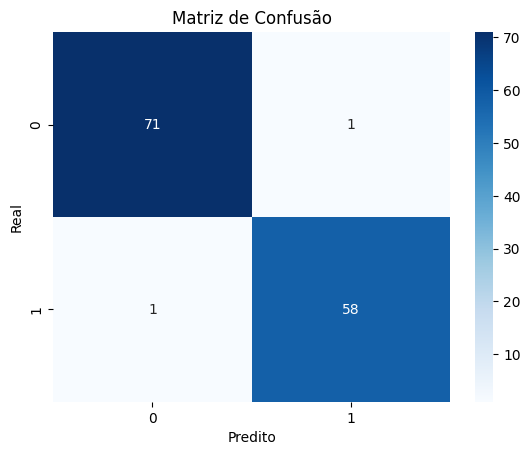

In [89]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

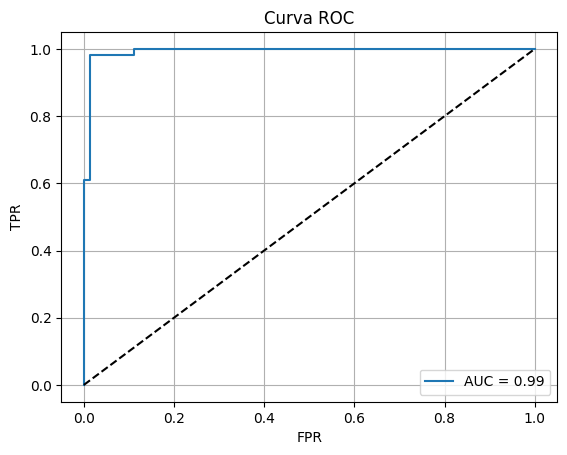

In [90]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Curva ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.grid(True)
plt.show()

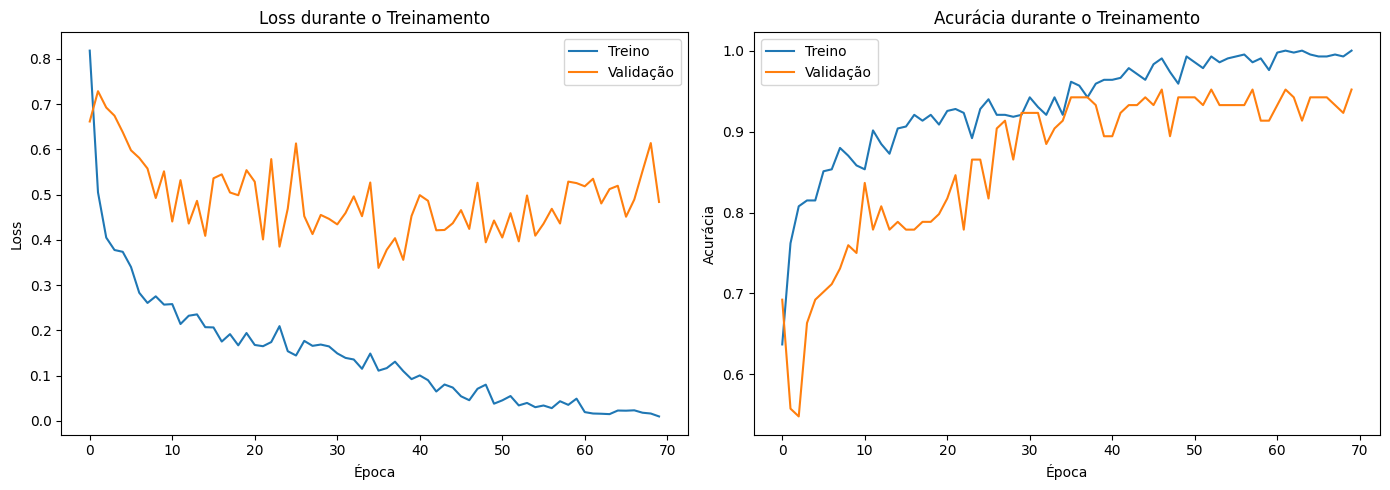

In [91]:
# Supondo que você salvou 'history' do model.fit(...)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()
